# Plot Tracks on Map

## Libs Sections 

In [1]:
import xarray as xr
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
#sns.set_context('talk')
import cartopy.crs as ccrs
import cartopy.feature as cf


import glob

import tobac
import sys
import json




## Arguments

In [2]:
if 'launcher' in sys.argv[0]:
    config_file = '../scripts/config/config_precip200.json'
    date = '202006'
    interactive = True
else:
    config_file = sys.argv[1]
    date = sys.argv[2]
    interactive = False

## Configuration

In [3]:
with open(config_file, "r") as fp:
    conf = json.load(fp)
globals().update(conf)

## Input Data 

In [4]:
main_dir = "/work/bb1376/user/fabian/data/oxford-hackathon"
subname = f"{vname}_tracks_thresh{threshold}"

input_dir = f"/{main_dir}/{model}/{experiment}/tracks"
infile = f'{input_dir}/monthly_{subname}_{date}.nc'

tracks = xr.open_dataset( infile )

/tmp/ipykernel_4100285/613922107.py:7: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  tracks = xr.open_dataset( infile )


In [6]:
tg = tracks.groupby('cell')

## Binning

In [40]:
dlon = 1.
dlat = 1.
lon_bins = np.arange(0, 360, dlon)  # 1-degree bins from -180 to 180
lat_bins = np.arange(-90, 91, dlat)     # 1-degree bins from -90 to 90

mlon = 0.5 * (lon_bins[1:] + lon_bins[:-1] )  
mlat = 0.5 * (lat_bins[1:] + lat_bins[:-1] )  

lon2d, lat2d = np.meshgrid( mlon, mlat )
phi = np.deg2rad( lat2d )

area = dlon * dlat * np.cos( phi )

wa = area / area.mean()

In [52]:
# Create a 2D histogram (count) of occurrences
counts, _, _ = np.histogram2d( tracks['latitude'], tracks['longitude'], bins=[lat_bins, lon_bins], weights = tracks['ones'])
totals, _, _ = np.histogram2d( tracks['latitude'], tracks['longitude'], bins=[lat_bins, lon_bins], weights = tracks['total'])


# Create an xarray DataArray
count_area_weighted = xr.DataArray(wa * counts, coords=[lat_bins[:-1], lon_bins[:-1]], dims=['latitude', 'longitude'])


# also use a totals weight
wt = area * totals /  ( area * totals).mean() 
count_totals_weighted = xr.DataArray(wt * counts, coords=[lat_bins[:-1], lon_bins[:-1]], dims=['latitude', 'longitude'])


## Plotting

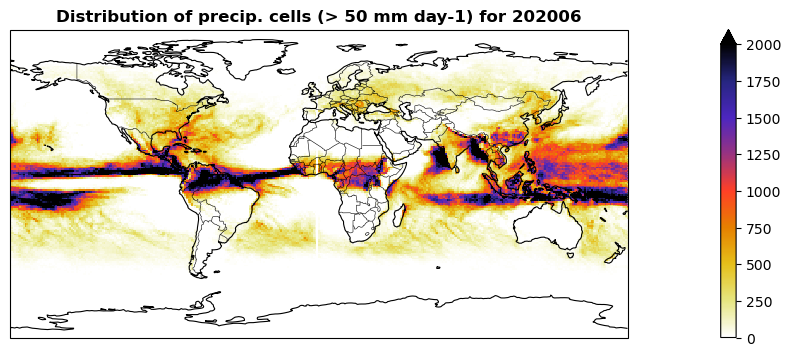

In [58]:
if interactive:
    target_map = ccrs.PlateCarree()
    fig, axs = plt.subplots(ncols=1, nrows = 1, subplot_kw={'projection': target_map}, figsize = (24,4))
    plt.sca( axs ) #[0] )
    

    count_area_weighted.plot(x = 'longitude', y = 'latitude', cmap = plt.cm.CMRmap_r, vmax = 2000.,
                       transform=ccrs.PlateCarree(),  # the data's projection
            subplot_kws={"projection": target_map},)

#    plt.colorbar( shrink = 0.7, label = f'Density of Precip Cells' )
#    xfeat.plot.scatter( x = 'longitude', y = 'latitude', markersize =size, 
#                       transform=ccrs.PlateCarree(),  # the data's projection
#            subplot_kws={"projection": target_map},)
    
    ax = plt.gca()
    ax.add_feature(cf.COASTLINE, linewidth=0.8)
    ax.add_feature(cf.BORDERS, linewidth=0.4)
    ax.set_title(f'Distribution of precip. cells (> 50 mm day-1) for {date}', fontweight = 'bold') 

Text(0.5, 1.0, 'Distribution of precip. cells (> 50 mm day-1) for 202006')

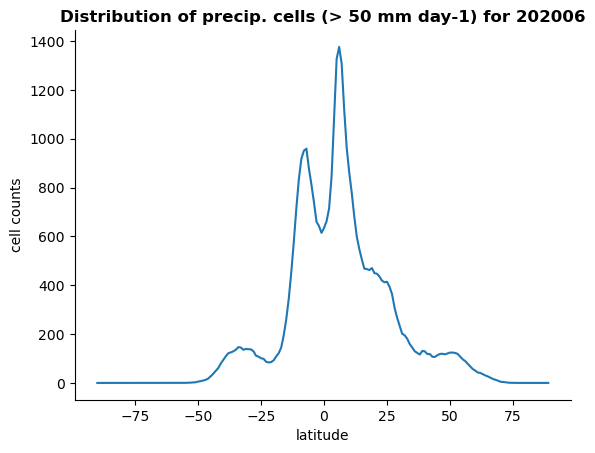

In [72]:

count_area_weighted.mean('longitude').plot()
sns.despine()
plt.ylabel('cell counts')
plt.title(f'Distribution of precip. cells (> 50 mm day-1) for {date}', fontweight = 'bold') 